> # import

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [23]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [24]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [25]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями



data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

sample_submission = pd.read_csv('sample_submission.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


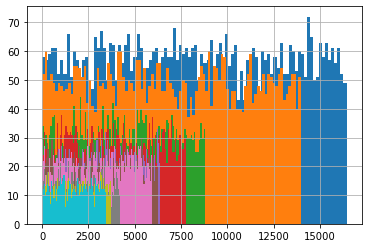

In [26]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

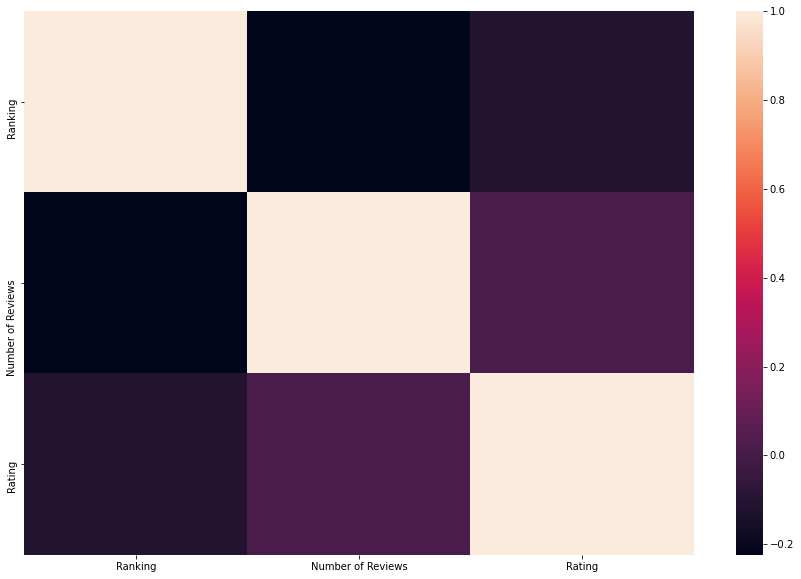

In [27]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [28]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки

    # ################### 2. NAN ##############################################################
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...

    df_output['Number of Reviews'].fillna(0, inplace=True)

    # ################### 3. Encoding ##############################################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na

    # ################### 4. Feature Engineering ####################################################

    ###########  ЦЕНА  ###########
    #### меням исходные значения на цифры, делаем переменную ранговой от 0 до 3-х ####

    price = []
    for i in range(50000):
        if df_output['Price Range'][i] == '$':
            price.append(1)
        elif df_output['Price Range'][i] == '$$ - $$$':
            price.append(2)
        elif df_output['Price Range'][i] == '$$$$':
            price.append(3)
        else:
            price.append(0)
    df_output['Price'] = pd.Series(price)

    #id_price_mean = df_output.groupby(['Restaurant_id'])['Price'].mean().round()

    #price_mean = []
    # for i in range (50000):
    #    if df_output['Price'][i] == 0:
    #        price_mean.append(id_price_mean.loc[df_output['Restaurant_id'][i]])
    #    else:
    #        price_mean.append(df_output['Price'][i])
    #df_output['Price_mean'] = pd.Series(price_mean).astype(int)

    ###########  КУХНЯ  ##########
    ####  считаем сколько типов кухонь представленно в одном ресторане ####

    df_output['Cuisine Style_isNAN'] = pd.isna(
        df_output['Cuisine Style']).astype('uint8')

    all_cuisine = []
    for i in range(50000):
        all_cuisine.append(str(df_output['Cuisine Style'][i]).count(',')+1)
    df_output['Cuisine_num'] = pd.Series(all_cuisine)

    ###########  ПРОМЕЖУТОК МЕЖДУ ОТЗЫВАМИ  ###########
    ### переводим, указанные в отзывах, даты отзыва в тип datetime 
    ### и вычисляем количиство дней, прошедших между двумя соседними отзывами

    df_output['Reviews_isNAN'] = pd.isna(df_output['Reviews']).astype('uint8')
    df_output['Reviews'].fillna(0, inplace=True)

    data['Reviews'].fillna(0, inplace=True)
    null_rev = '[[], []]'
    
    time_1 = []
    time_2 = []
    time_3 = []

    for i in range(50000):
        if data['Reviews'][i] == 0:
            time_1.append(['', "01/01/1999', '01/01/1999']]"])
        elif data['Reviews'][i] != null_rev:
            time_1.append(str(data.Reviews.iloc[i]).split("], ['"))
        else:
            time_1.append(['', "01/01/1999', '01/01/1999']]"])

    for i in range(len(time_1)):
        if len(time_1[i][1]) < 13:
            time_2.append(time_1[i][1][0:time_1[i][1].find("']]")])
        else:
            time_2.append(time_1[i][1][0:time_1[i][1].find("], ['")+11])

    for i in range(50000):
        time_3.append(time_1[i][1][-13:time_1[i][1].find("']]")])

    data['time_1'] = pd.Series(time_2)
    data['time_2'] = pd.Series(time_3)

    data['time_1'] = pd.to_datetime(data['time_1'])
    data['time_2'] = pd.to_datetime(data['time_2'])

    data['time_3'] = data['time_1'] - data['time_2']

    str_time_3 = []
    for i in range(len(data)):
        str_time_3.append(str(data['time_3'][i]))

    str_time_4 = []
    int_time_4 = []
    for i in range(len(str_time_3)):
        str_time_4.append(str_time_3[i][1:str_time_3[i].find(' ')])
    data['time_4'] = pd.Series(str_time_4)

    for i in range(len(str_time_4)):
        if data['time_4'][i] != '':
            int_time_4.append(int(data['time_4'][i]))
        else:
            int_time_4.append(0)

    data['time_4'] = pd.Series(int_time_4)

    ###########  КОЛИЧЕСТВО РЕСТОРАНОВ В ГОРОДЕ  ###########

    df_output['Cuisine Style_isNAN'] = pd.isna(
        df_output['Cuisine Style']).astype('uint8')
    
    df_output['Cuisine Style'].fillna(0, inplace=True)

    dictionary_city = {}

    for i in range(len(df_output['City'].unique())):
        dictionary_city[df_output['City'].unique()[i]] = len(
            df_output[df_output['City'] == df_output['City'].unique()[i]])

    number_rest_city = []
    for i in range(50000):
        number_rest_city.append(dictionary_city[df_output['City'][i]])
    df_output['number_rest_city'] = pd.Series(number_rest_city)

    ##########  КУХНЯ  ###########
    ### создаём dummies переменные с типом кухни

    def find_item(cell):
        if item in cell:
            return 1
        return 0

    list_cus_1 = []

    df2 = df_output['Cuisine Style'].value_counts()
    for i in range(1, len(df_output['Cuisine Style'].value_counts())):
        list_cus_1.append(df_output['Cuisine Style'].value_counts(
        ).index[i][1:-1].split(','))

    list_cus_2 = []
    for i in range(len(list_cus_1)):
        for j in range(len(list_cus_1[i])):
            list_cus_2.append(list_cus_1[i][j][(str(list_cus_1[i][j]).find("'")+1):-1])
    list_cus_3 = pd.Series(list_cus_2)

    cus = []
    for i in range(50000):
        cus.append(str(df_output['Cuisine Style'][i]))
    df_output['cus'] = pd.Series(cus)

    for item in list_cus_3.unique():
        df_output[item] = df_output['cus'].apply(find_item)

    ###########  ПОДСЧЕТ ПОЛОЖИТЕЛЬНЫХ И ОТРИЦАТЕЛЬНЫХ СЛОВ В РЕЦЕНЗИЯХ  ###########

    positive = []
    for line in open('positive-words.txt'):
        if ';' in line:
            continue
        else:
            positive.append(line[:-1])
    positive = positive[1:]

    negative = []
    for line in open('negative-words.txt'):
        if ';' in line:
            continue
        else:
            negative.append(line[:-1])
    negative = negative[1:]

    rew_1 = []
    rew_2 = []
    pos_word = []
    neg_word = []
    
    for i in range(50000):
        rew_1.append(time_1[i][0][0:time_1[i][0].find("], ['")].lower())
    for i in range(50000):
        rew_1[i] = re.sub('|\]|\[|\|\,|\?|\'|\.|\!|\/|\;|\:|\,', '', rew_1[i])
    for i in range(50000):
        rew_2.append(rew_1[i].split())

    for i in range(50000):
        pos_count = 0
        for j in rew_2[i]:
            if j in positive:
                pos_count += 1
        pos_word.append(pos_count)

    for i in range(50000):
        neg_count = 0
        for j in rew_2[i]:
            if j in negative:
                neg_count += 1
        neg_word.append(neg_count)
    df_output['pos_word'] = pd.Series(pos_word)
    df_output['neg_word'] = pd.Series(neg_word)

    ###########  НАСЕЛЕНИЕ ГОРОДА  ###########

    population = {'London': 9304000,
                  'Paris': 2148000,
                  'Madrid': 6618000,
                  'Barcelona': 5586000,
                  'Berlin': 3562000,
                  'Milan': 3140000,
                  'Rome': 4257000,
                  'Prague': 1306000,
                  'Lisbon': 2957000,
                  'Vienna': 1930000,
                  'Amsterdam': 1149000,
                  'Brussels': 2081000,
                  'Hamburg': 1845000,
                  'Munich': 1538000,
                  'Lyon': 1719000,
                  'Stockholm': 1633000,
                  'Budapest': 1768000,
                  'Warsaw': 1783000,
                  'Dublin': 1228000,
                  'Copenhagen': 794128,
                  'Athens': 3153000,
                  'Edinburgh': 537000,
                  'Zurich': 1395000,
                  'Oporto': 1312947,
                  'Geneva': 613373,
                  'Krakow': 768713,
                  'Oslo': 1041377,
                  'Helsinki': 1305000,
                  'Bratislava': 435000,
                  'Luxembourg': 625978,
                  'Ljubljana': 288307}

    df_output['population'] = df_output['City'].apply(
        lambda city: population[city])

    ###########  СТРАНА  ###########
    
    country = {'London': 'United Kingdom',
               'Paris': 'France',
               'Madrid': 'Spain',
               'Barcelona': 'Spain',
               'Berlin': 'Germany',
               'Milan': 'Italy',
               'Rome': 'Italy',
               'Prague': 'Czech',
               'Lisbon': 'Portugal',
               'Vienna': 'Austria',
               'Amsterdam': 'Niderland',
               'Brussels': 'Belgique',
               'Hamburg': 'Germany',
               'Munich': 'Germany',
               'Lyon': 'France',
               'Stockholm': 'Sweden',
               'Budapest': 'Hungary',
               'Warsaw': 'Poland',
               'Dublin': 'Ireland',
               'Copenhagen': 'Danmark',
               'Athens': 'Greece',
               'Edinburgh': 'United Kingdom',
               'Zurich': 'Switzerland',
               'Oporto': 'Portugal',
               'Geneva': 'Switzerland',
               'Krakow': 'Poland',
               'Oslo': 'Norway',
               'Helsinki': 'Finland',
               'Bratislava': 'Slovakia',
               'Luxembourg': 'Luxembourg',
               'Ljubljana': 'Slovenia'}

    df_output['country'] = df_output['City'].apply(lambda city: country[city])

    dummies_country = pd.get_dummies(df_output['country'])

    for i in range(len(dummies_country.columns)):
        df_output[dummies_country.columns[i]
                  ] = dummies_country[dummies_country.columns[i]]

    ###########  ТУРИСТИЧЕСКИЙ ПОТОК В СТРАНУ  ###########
    
    tourist_flow = {'United Kingdom': 3631600,
                    'France': 8932200,
                    'Spain': 8277300,
                    'Germany': 3888100,
                    'Italy': 6156720,
                    'Czech': 1061100,
                    'Portugal': 1618600,
                    'Austria': 3081600,
                    'Niderland': 1878000,
                    'Belgique': 911900,
                    'Sweden': 744000,
                    'Hungary': 1755200,
                    'Poland': 1962200,
                    'Ireland': 1092600,
                    'Danmark': 1274900,
                    'Greece': 3012300,
                    'Switzerland': 1036200,
                    'Norway': 568800,
                    'Finland': 322400,
                    'Slovakia': 225600,
                    'Luxembourg': 101800,
                    'Slovenia': 442500}

    df_output['tourist_flow'] = df_output['country'].apply(
        lambda country: tourist_flow[country])

    ###########  КОЛИЧЕСТВО РЕСТОРАНОВ В СТРАНЕ, ИМЕЮЩИХ ЗВЕДУ МИШЛЕН  ###########
    
    
    michelin = {'United Kingdom': 1220,
                'France': 3369,
                'Spain': 1274,
                'Germany': 1507,
                'Italy': 2055,
                'Czech': 27,
                'Portugal': 155,
                'Austria': 82,
                'Niderland': 562,
                'Belgique': 849,
                'Sweden': 76,
                'Hungary': 21,
                'Poland': 38,
                'Ireland': 153,
                'Danmark': 89,
                'Greece': 20,
                'Switzerland': 608,
                'Norway': 38,
                'Finland': 30,
                'Slovakia': 0,
                'Luxembourg': 59,
                'Slovenia': 52}

    df_output['michelin'] = df_output['country'].apply(
        lambda country: michelin[country])

    ###########  ПЛОЩАДЬ ГОРОДА  ###########
    
    sq = {'London': 1572,
          'Paris': 105.4,
          'Madrid': 604.3,
          'Barcelona': 101.9,
          'Berlin': 891.8,
          'Milan': 181.8,
          'Rome': 1285,
          'Prague': 496,
          'Lisbon': 100,
          'Vienna': 414.6,
          'Amsterdam': 219.3,
          'Brussels': 32.61,
          'Hamburg': 755.2,
          'Munich': 310.4,
          'Lyon': 47.87,
          'Stockholm': 188,
          'Budapest': 525.2,
          'Warsaw': 517.2,
          'Dublin': 115,
          'Copenhagen': 88.25,
          'Athens': 38964,
          'Edinburgh': 264,
          'Zurich': 87.88,
          'Oporto': 41.42,
          'Geneva': 41.42,
          'Krakow': 327,
          'Oslo': 454,
          'Helsinki': 213.8,
          'Bratislava': 367.6,
          'Luxembourg': 2586,
          'Ljubljana': 163.8}

    df_output['sq'] = df_output['City'].apply(lambda city: sq[city])

    
    ###########  ID РЕСТОРАНА В TA  ###########
    ### есть зависимость от ID в TA, скорее всего связанно с датой создания учетной записи в ТА/возраст ресторана 
    
    id_rest_ta = []
    for i in range(50000):
        id_rest_ta.append(int(df_output['ID_TA'][i][1:]))

    df_output['id_rest_ta'] = pd.Series(id_rest_ta)

    ###########  НОРМАЛИЗАЦИЯ РАНКИНГА  ###########
    
    df_output['mean_rank'] = df_output['Ranking'] / \
        df_output['City'].map(df_output.groupby(['City'])['Ranking'].max())

    ###########  СРЕДНЯЯ ЦЕНА/ЧЕК В ГОРОДЕ  ###########
    
    df_output['mean_price'] = df_output['City'].map(
        df_output.groupby(['City'])['Price'].mean())
    
    ###########  СРЕДНЯЯ КОЛИЧЕСТВО ОТЗЫВОВ В ГОРОДЕ  ###########

    df_output['mean_num_reviews'] = df_output['Number of Reviews'] / \
        df_output['City'].map(df_output.groupby(
            ['City'])['Number of Reviews'].max())

    ###########  ПЛОТНОСТЬ РЕСТОРАНОВ В ГОРОДЕ НА ЧЕЛОВЕКА  ###########
    
    df_output['rest_density'] = df_output['number_rest_city'] / \
        df_output['population']

    ###########  ПЛОТНОСТЬ РЕСТОРАНОВ В ГОРОДЕ НА ЕД. ПЛОЩАДИ  ###########
    
    df_output['rest_density_sq'] = df_output['number_rest_city'] / \
        df_output['sq']

    ###########  ЯВЛЯЕТСЯ ЛИ ГОРОД СТОЛИЦЕЙ  ###########
    
    city_cap = ['London',
                'Paris',
                'Stockholm',
                'Madrid',
                'Berlin',
                'Rome',
                'Prague',
                'Lisbon',
                'Vienna',
                'Amsterdam',
                'Budapest',
                'Warsaw',
                'Dublin',
                'Copenhagen',
                'Athens',
                'Edinburgh',
                'Oslo',
                'Helsinki',
                'Bratislava',
                'Ljubljana',
                'Brussels',
                'Luxembourg']

    df_output['city_capital'] = df_output['City'].apply(
        lambda x: 1 if x in city_cap else 0)

    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)

    # ################### 5. Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
        
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object'
                      or df_output[s].dtypes == 'datetime64[ns]'
                      or df_output[s].dtypes == 'timedelta64[ns]']
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [29]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Price,Cuisine Style_isNAN,Cuisine_num,Reviews_isNAN,number_rest_city,Italian,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
4485,2725.0,0.0,0,0.0,0,0,3,0,1443,0,...,0,0,0,0,0,0,1,0,0,0
1270,9066.0,0.0,0,0.0,0,1,1,0,7193,0,...,0,0,0,0,0,0,0,0,0,0
18261,3077.0,18.0,1,4.5,0,1,1,0,3395,0,...,0,0,0,0,0,0,0,0,0,0
48638,1925.0,0.0,1,5.0,0,0,1,0,1816,0,...,0,0,0,1,0,0,0,0,0,0
17901,1003.0,25.0,1,4.0,0,1,1,0,776,0,...,0,0,0,0,0,0,0,0,0,0
27098,7996.0,3.0,1,5.0,0,1,1,0,6108,0,...,0,0,1,0,0,0,0,0,0,0
36071,3555.0,6.0,1,5.0,2,0,6,0,1816,0,...,0,0,0,1,0,0,0,0,0,0
5000,492.0,920.0,0,0.0,2,0,4,0,7193,0,...,0,0,0,0,0,0,0,0,0,0
4722,2754.0,4.0,0,0.0,1,0,1,0,2705,0,...,0,0,0,0,0,0,0,0,0,0
45100,5606.0,17.0,1,3.0,0,0,1,0,2694,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 200 entries, Ranking to City_nan
dtypes: float64(9), int64(135), uint8(56)
memory usage: 57.6 MB


In [31]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [32]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [33]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 199), (40000, 199), (40000, 198), (32000, 198), (8000, 198))

# Model 
Сам ML

In [34]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [35]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [36]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [37]:
#ОКРУГЛЕНИЕ

y_pred_round = []
for i in range (len(y_pred)):
    y_pred_round.append((y_pred[i]*2).round()/2)
y_pred = y_pred_round

In [38]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1660625


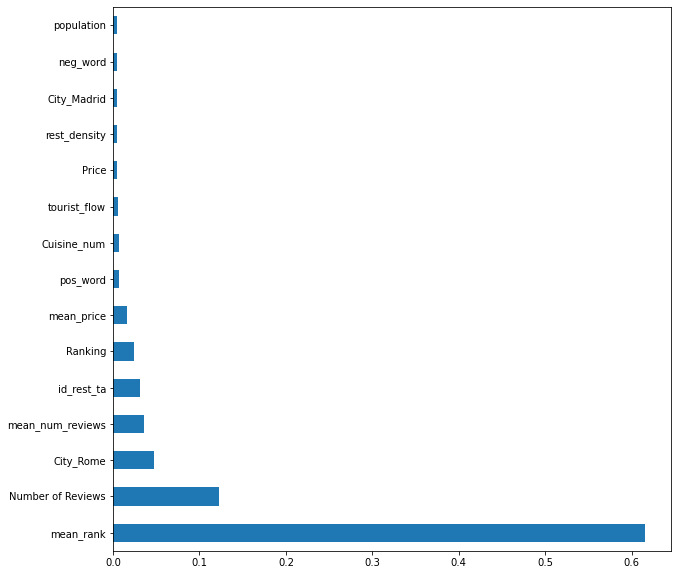

In [39]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [40]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Price,Cuisine Style_isNAN,Cuisine_num,Reviews_isNAN,number_rest_city,Italian,French,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
9068,1246.0,62.0,0.0,2,0,4,0,3395,0,0,...,0,0,0,0,0,0,0,0,0,0
7586,6973.0,21.0,0.0,0,1,1,0,6108,0,0,...,0,0,1,0,0,0,0,0,0,0
5898,8379.0,18.0,0.0,0,0,1,0,6108,0,0,...,0,0,1,0,0,0,0,0,0,0
6784,468.0,193.0,0.0,2,0,5,0,6108,1,0,...,0,0,1,0,0,0,0,0,0,0
4784,185.0,1698.0,0.0,2,0,4,0,7193,0,0,...,0,0,0,0,0,0,0,0,0,0
3412,31.0,236.0,0.0,2,0,3,0,1186,0,0,...,0,0,0,0,0,0,0,0,0,0
8627,1074.0,25.0,0.0,1,0,2,0,1816,0,0,...,0,0,0,1,0,0,0,0,0,0
4461,1829.0,340.0,0.0,2,0,3,0,2694,0,0,...,0,0,0,0,0,0,0,0,0,0
6711,2185.0,2.0,0.0,0,1,1,0,1033,0,0,...,0,0,0,0,0,1,0,0,0,0
5822,1833.0,3.0,0.0,0,1,1,0,1443,0,0,...,0,0,0,0,0,0,1,0,0,0


In [41]:
test_data = test_data.drop(['Rating'], axis=1)

In [42]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [43]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [44]:
predict_submission_round = []
for i in range (len(predict_submission)):
    predict_submission_round.append((predict_submission[i]*2).round()/2)
predict_submission = predict_submission_round
predict_submission

[3.0,
 4.0,
 4.5,
 4.5,
 4.5,
 4.5,
 2.0,
 3.5,
 4.0,
 4.5,
 4.0,
 3.5,
 4.0,
 4.0,
 3.5,
 3.0,
 3.5,
 4.0,
 2.5,
 4.0,
 3.5,
 4.5,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 3.5,
 3.5,
 4.0,
 5.0,
 3.5,
 3.5,
 4.5,
 3.5,
 4.5,
 4.5,
 4.0,
 5.0,
 4.5,
 3.0,
 4.0,
 3.5,
 4.0,
 3.0,
 4.0,
 4.0,
 5.0,
 3.5,
 3.5,
 4.5,
 4.0,
 5.0,
 4.0,
 3.5,
 3.5,
 4.0,
 4.0,
 4.5,
 4.5,
 5.0,
 4.5,
 4.0,
 4.5,
 3.5,
 4.5,
 4.5,
 4.0,
 4.5,
 2.5,
 4.5,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 3.5,
 4.0,
 3.0,
 4.5,
 5.0,
 4.0,
 3.5,
 4.5,
 3.0,
 4.0,
 4.5,
 4.5,
 4.0,
 3.5,
 4.5,
 4.0,
 4.0,
 3.0,
 3.5,
 4.0,
 3.0,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.5,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.5,
 4.5,
 3.5,
 4.0,
 5.0,
 4.0,
 4.5,
 3.5,
 4.0,
 3.5,
 5.0,
 4.0,
 4.5,
 4.0,
 4.0,
 3.5,
 3.5,
 2.5,
 4.5,
 4.0,
 3.5,
 4.0,
 4.5,
 3.0,
 4.0,
 4.0,
 4.0,
 4.5,
 5.0,
 4.0,
 5.0,
 4.5,
 3.5,
 3.5,
 4.5,
 3.5,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.5,
 1.0,
 4.5,
 4.5,
 4.5,
 3.5,
 4.0,
 4.0,
 4.0,
 3.5,
 4.5,
 4.0,
 4.0,
 4.5,
 3.5

In [45]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
